In [1]:
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

# Change to the project root directory
project_root = pathlib.Path("/Users/victormp/Desktop/ml/ml-project")
os.chdir(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models import ARIMA
from darts import TimeSeries
import torch
import torch.nn as nn
from src.train import train_tcn_model
from src.train import train_additive_model


The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


# Import Data

In [2]:
data_path = pathlib.Path("data/DCOILWTICO.csv")
print(f"Loading from: {data_path.absolute()}")
print(f"File exists: {data_path.exists()}")

data = pd.read_csv(data_path)
data.rename(columns = {"observation_date" : "date", "DCOILWTICO" : "price"}, inplace  = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data["return"] = np.log(data["price"]) - np.log(data["price"].shift(1))
returns = data["return"].replace([np.inf, -np.inf], np.nan).dropna().astype("float32")

Loading from: /Users/victormp/Desktop/ml/ml-project/data/DCOILWTICO.csv
File exists: True


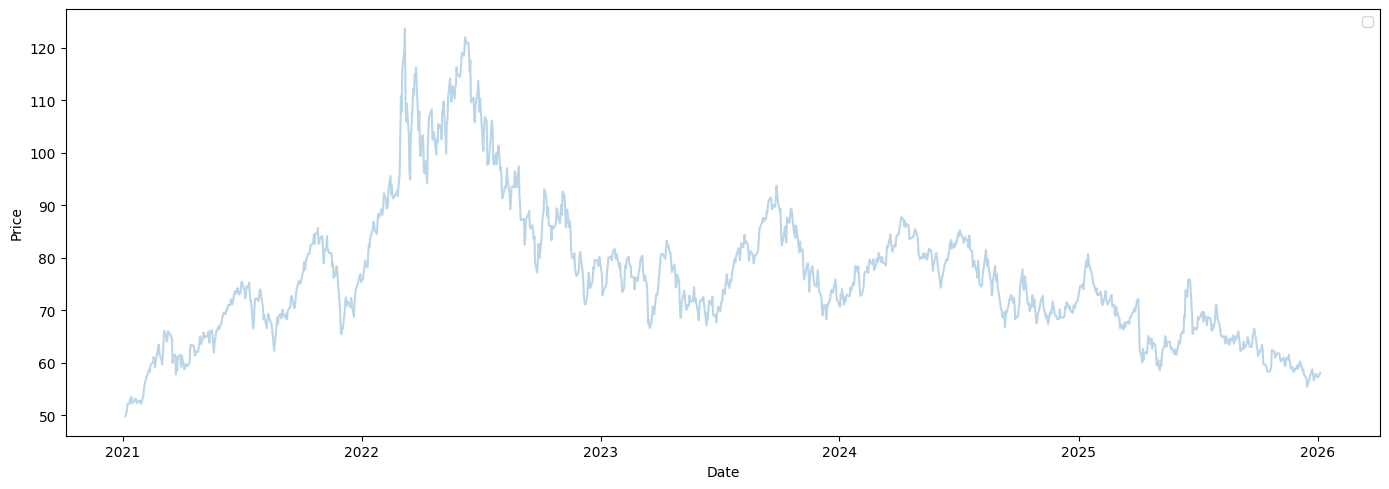

In [3]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = data.index, y = data["price"], alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()

# Split Data

In [4]:
split_point = int(len(returns) * 0.8)  # 80% train, 20% test
y_train = returns.iloc[:split_point]
y_test = returns.iloc[split_point:]

# Convert y_train["return"] and y_test["return"] to darts TimeSeries objects
train_series = TimeSeries.from_values(y_train)
test_series = TimeSeries.from_values(y_test)

# Train AR Model
### Calculate residuals, preditions on training set, and the MSE

In [5]:
#Flexible AR model
AR_ORDERS = [1, 5]

# Dictionary to store results
ar_results = {}


for ar_order in AR_ORDERS:

    if os.path.exists(f"weights/model_weights_ar{ar_order}.pkl"):
        with open(f"weights/model_weights_ar{ar_order}.pkl", "rb") as f:
            model = ARIMA.load(f)
            print(f"Loaded model weights from weights/model_weights_ar{ar_order}.pkl")
        
        print("="*60)
        print(f"Fitting AR({ar_order}) Model")
        print("="*60)

        model.fit(train_series)
        residuals = model.residuals(train_series)
        train_series_predict = model.predict(len(train_series))

        # To avoid nan, only compute MSE on pairs where both are not nan
        pred_vals = train_series_predict.values().flatten()
        true_vals = train_series.values().flatten()

        # Remove pairs where either is nan
        mask = ~np.isnan(pred_vals) & ~np.isnan(true_vals)
        mse = np.mean((true_vals[mask] - pred_vals[mask]) ** 2)
        mae = np.mean(np.absolute(true_vals[mask] - pred_vals[mask]))

        print(f"AR({ar_order}) MSE on training data: {mse:.6f}")
        print(f"AR({ar_order}) MAE on training data: {mae:.6f}")

        # Store results for later use
        ar_results[ar_order] = {
            'model': model,
            'residuals': residuals,
            'predictions': train_series_predict,
            'mse': mse, 
            'mae': mae, 
        }
        print()

    else:

        print(f"Model_weights_ar{ar_order}.pkl does not exist.")
        print("="*60)
        print(f"Fitting AR({ar_order}) Model")
        print("="*60)

        # Train model and calculate residuals, compute MSE
        model = ARIMA(p=ar_order, d=0, q=0)
        model.fit(train_series)
        model.save(f'weights/model_weights_ar{ar_order}.pkl')
        residuals = model.residuals(train_series)
        train_series_predict = model.predict(len(train_series))

        # To avoid nan, only compute MSE on pairs where both are not nan
        pred_vals = train_series_predict.values().flatten()
        true_vals = train_series.values().flatten()

        # Remove pairs where either is nan
        mask = ~np.isnan(pred_vals) & ~np.isnan(true_vals)
        mse = np.mean((true_vals[mask] - pred_vals[mask]) ** 2)
        mae = np.mean(np.absolute(true_vals[mask] - pred_vals[mask]))

        print(f"AR({ar_order}) MSE on training data: {mse:.6f}")
        print(f"AR({ar_order}) MAE on training data: {mae:.6f}")

        # Store results for later use
        ar_results[ar_order] = {
            'model': model,
            'residuals': residuals,
            'predictions': train_series_predict,
            'mse': mse, 
            'mae': mae, 
        }
        print()

print("="*60)
for ar_order in AR_ORDERS:
    print(f" AR({ar_order}) available in ar_results[{ar_order}]['model']")

print("="*60)


Loaded model weights from weights/model_weights_ar1.pkl
Fitting AR(1) Model
AR(1) MSE on training data: 0.000524
AR(1) MAE on training data: 0.017440

Loaded model weights from weights/model_weights_ar5.pkl
Fitting AR(5) Model
AR(5) MSE on training data: 0.000524
AR(5) MAE on training data: 0.017445

 AR(1) available in ar_results[1]['model']
 AR(5) available in ar_results[5]['model']


# Train TCN

In [38]:
if os.path.exists("weights/model_weights_classic_tcn.pth"):
    try:
        from src.models import Classic_TCN
        model_classic_tcn = Classic_TCN(kernel_size=3, 
                                        num_filters=64, 
                                        num_layers=5, 
                                        dilation_base=4)
        model_classic_tcn.load_state_dict(torch.load("weights/model_weights_classic_tcn.pth"))
        model_classic_tcn.eval()
        print(f"Loaded model weights from weights/model_weights_classic_tcn.pth")

    except RuntimeError as e:
        print(f"Model architecture mismatch: {e}")
        print(f"Training new model (AR order: {ar_order})...")
        model_classic_tcn = train_tcn_model(y_train.values, num_epochs=150)
        torch.save(model.state_dict(), "weights/model_weights_classic_tcn.pth")
        print(f"Model trained and saved to {"weights/model_weights_classic_tcn.pth"}")
else:
    print("=" * 60)
    print("Training Classic TCN")
    print("=" * 60)
    model_classic_tcn = train_tcn_model(y_train.values, num_epochs=150)
    torch.save(model.state_dict(), "weights/model_weights_classic_tcn.pth")
    print("Model trained and saved to weights/model_weights_classic_tcn.pth")

Loaded model weights from weights/model_weights_classic_tcn.pth


# Train Hybrid AR-TCN

In [39]:
#Loop to train the AR model to be flexible
AR_ORDERS = [1, 5]  # Train both AR(1)+TCN and AR(5)+TCN

hybrid_results = {}

for ar_order in AR_ORDERS:
    weights_path = f"weights/model_weights_hybrid_ar{ar_order}.pth"

    if os.path.exists(f"weights/model_weights_hybrid_ar{ar_order}.pth"):
        try:
            from src.models import AdditiveHybrid_AR_TCN
            model = AdditiveHybrid_AR_TCN(ar_order=ar_order,
                                            kernel_size=3, 
                                            num_filters=64, 
                                            num_layers=3, 
                                            dilation_base=2)
            model.load_state_dict(torch.load(weights_path))
            model.eval()
            print(f"Loaded model weights from {weights_path}")
            # Store the model
            hybrid_results[ar_order] = {
                'model': model,
            }
        except RuntimeError as e:
            print(f"Model architecture mismatch: {e}")
            print(f"Training new model (AR order: {ar_order})...")
            model = train_additive_model(y_train, ar_order=ar_order, num_epochs=100, lr=0.001)
            torch.save(model.state_dict(), weights_path)
            print(f"Model trained and saved to {weights_path}")
            # Store the model
            hybrid_results[ar_order] = {
                'model': model,
            }
    else:
        print(f"Weights file not found: {weights_path}")
        print(f"Training new model (AR order: {ar_order})...")
        model = train_additive_model(y_train, ar_order=ar_order, num_epochs=100, lr=0.001)
        torch.save(model.state_dict(), weights_path)
        print(f"Model trained and saved to {weights_path}")
        # Store the model
        hybrid_results[ar_order] = {
            'model': model,
        }
    
# Summary
print("="*60)
print("Hybrid Models Ready")
print("="*60)
for ar_order in AR_ORDERS:
    print(f" AR({ar_order}) + TCN model available in hybrid_results[{ar_order}]")
print("="*60)

Loaded model weights from weights/model_weights_hybrid_ar1.pth
Loaded model weights from weights/model_weights_hybrid_ar5.pth
Hybrid Models Ready
 AR(1) + TCN model available in hybrid_results[1]
 AR(5) + TCN model available in hybrid_results[5]


In [40]:
# Extract models
model_hybrid_ar1 = hybrid_results[1]["model"]
model_hybrid_ar5 = hybrid_results[5]["model"]
model_ar1 = ar_results[1]["model"]
model_ar5 = ar_results[5]["model"]

# Evaluate models
model_classic_tcn.eval()
model_hybrid_ar1.eval()
model_hybrid_ar5.eval()

with torch.no_grad():
    y_train_tensor = torch.FloatTensor(y_train.values)

    predictions_class, targets_class = model_classic_tcn(y_train_tensor)
    predictions_add1, targets_add1 = model_hybrid_ar1(y_train_tensor)
    predictions_add5, targets_add5 = model_hybrid_ar5(y_train_tensor)

    print(f"AR prediction shape: {pred_vals.shape}")
    print(f"Classic prediction shape: {predictions_class.shape}")
    print(f"Additive prediction shape: {predictions_add1.shape}")

# Calculate MSE
y_train_adj = y_train.values[1:]  # Adjust for the shift in predictions
predictions_class_np = predictions_class.numpy().flatten()
predictions_add1_np = predictions_add1.numpy().flatten()
predictions_add5_np = predictions_add1.numpy().flatten()

mse_class = np.mean((y_train_adj - predictions_class_np) ** 2)
mse_hybrid_add1 = np.mean((y_train_adj - predictions_add1_np) ** 2)
mse_hybrid_add5 = np.mean((y_train_adj - predictions_add5_np) ** 2)

mae_class = np.mean(np.absolute(y_train_adj - predictions_class_np))
mae_hybrid_add1 = np.mean(np.absolute(y_train_adj - predictions_add1_np))
mae_hybrid_add5 = np.mean(np.absolute(y_train_adj - predictions_add5_np))

print("\n" + "=" * 60)
print("FINAL RESULTS - True Hybrid Models)")
print("=" * 60)
print(f"MSE AR(1):                                 {ar_results[1]["mse"]:.6f}")
print(f"MSE AR(5):                                 {ar_results[5]["mse"]:.6f}")
print(f"MSE Classic TCN:                           {mse_class:.6f}")
print(f"MSE Hybrid AR(1) + TCN (L + N):            {mse_hybrid_add1:.6f}")
print(f"MSE Hybrid AR(5) + TCN (L + N):            {mse_hybrid_add5:.6f}")
print("=" * 60)
print(f"MAE AR(1):                                 {ar_results[1]["mae"]:.6f}")
print(f"MAE AR(5):                                 {ar_results[5]["mae"]:.6f}")
print(f"MAE Classic TCN:                           {mae_class:.6f}")
print(f"MAE Hybrid AR(1) + TCN (L + N):            {mae_hybrid_add1:.6f}")
print(f"MAE Hybrid AR(5) + TCN (L + N):            {mae_hybrid_add5:.6f}")
print("=" * 60)


AR prediction shape: (954,)
Classic prediction shape: torch.Size([1, 953, 1])
Additive prediction shape: torch.Size([1, 953, 1])

FINAL RESULTS - True Hybrid Models)
MSE AR(1):                                 0.000524
MSE AR(5):                                 0.000524
MSE Classic TCN:                           0.000517
MSE Hybrid AR(1) + TCN (L + N):            0.000426
MSE Hybrid AR(5) + TCN (L + N):            0.000426
MAE AR(1):                                 0.017440
MAE AR(5):                                 0.017445
MAE Classic TCN:                           0.017341
MAE Hybrid AR(1) + TCN (L + N):            0.015715
MAE Hybrid AR(5) + TCN (L + N):            0.015715


In [42]:
forecast_horizon = [1, 2, 3, 5, 10, 30, 50]
results_mse_df = pd.DataFrame(columns=[f"{time}-step MSE" for time in forecast_horizon])
results_mae_df = pd.DataFrame(columns=[f"{time}-step MAE" for time in forecast_horizon])


for ar in AR_ORDERS:
    model = ar_results[ar]["model"]
    for time in forecast_horizon:
        prediction = model.predict(time).values().flatten()
        y_test_vals = y_test[:time]
        mse = np.mean((y_test_vals - prediction)**2)
        mae = np.mean(np.absolute(y_test_vals - prediction))
        results_mse_df.loc[f"AR({ar})", f"{time}-step MSE"] = mse
        results_mae_df.loc[f"AR({ar})", f"{time}-step MAE"] = mae
        # Reset variables
        del prediction, y_test_vals, mse, mae

for time in forecast_horizon:
    with torch.no_grad():
        prediction = model_classic_tcn.predict(y_train_tensor[:-100], steps = time).numpy()
    y_test_vals = y_test[:time]
    mse = np.mean((y_test_vals - prediction)**2)
    mae = np.mean(np.absolute(y_test_vals - prediction))
    results_mse_df.loc[f"TCN", f"{time}-step MSE"] = mse
    results_mae_df.loc[f"TCN", f"{time}-step MAE"] = mae
    # Reset variables
    del prediction, y_test_vals, mse, mae
    
for ar in AR_ORDERS:
    model = globals()[f"model_hybrid_ar{ar}"]
    for time in forecast_horizon:
        with torch.no_grad():
            prediction = model.predict(y_train_tensor[:-100], steps = time).numpy()
        y_test_vals = y_test[:time]
        mse = np.mean((y_test_vals - prediction)**2)
        mae = np.mean(np.absolute(y_test_vals - prediction))
        results_mse_df.loc[f"AR({ar})+TCN", f"{time}-step MSE"] = mse
        results_mae_df.loc[f"AR({ar})+TCN", f"{time}-step MAE"] = mae
        # Reset variables
        del prediction, y_test_vals, mse, mae

In [43]:
results_mse_df

,1-step MSE,2-step MSE,3-step MSE,5-step MSE,10-step MSE,30-step MSE,50-step MSE
AR(1),0.000135,0.000083,0.000083,0.000078,0.000278,0.000214,0.000221
AR(5),0.000144,0.000089,0.00009,0.000075,0.000274,0.000213,0.00022
TCN,0.001759,0.001511,0.001517,0.001365,0.001585,0.00101,0.000959
AR(1)+TCN,0.000584,0.000447,0.000456,0.000408,0.000681,0.000554,0.002038
AR(5)+TCN,0.000138,0.00003,0.000006,0.000066,0.00028,0.0002,0.000212


In [44]:
results_mae_df

,1-step MAE,2-step MAE,3-step MAE,5-step MAE,10-step MAE,30-step MAE,50-step MAE
AR(1),0.011638,0.008609,0.008788,0.008449,0.014262,0.012273,0.012115
AR(5),0.012011,0.008897,0.009145,0.00807,0.014035,0.012194,0.012068
TCN,0.041941,0.038741,0.038859,0.036419,0.036782,0.028261,0.027337
AR(1)+TCN,0.024169,0.020905,0.021195,0.019287,0.021698,0.018943,0.041348
AR(5)+TCN,0.011738,0.004798,0.001882,0.006091,0.013888,0.011325,0.011759


# Plots

### Plot AR

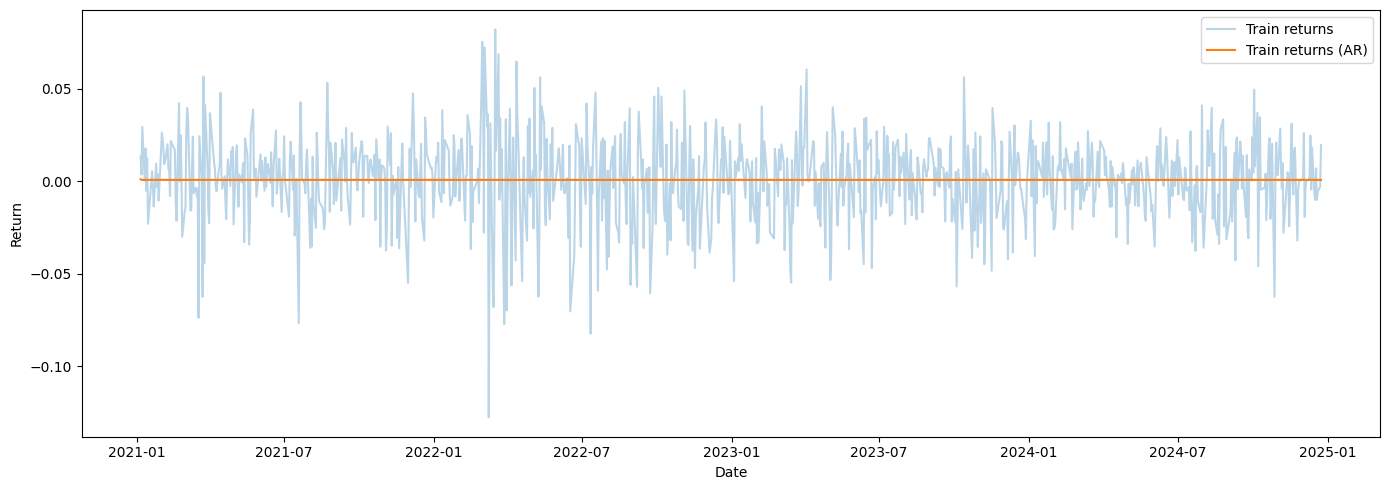

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train.index, y = y_train, alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train.index, y = ar_results[1]["predictions"].univariate_values(), label = "Train returns (AR)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Classic TCN

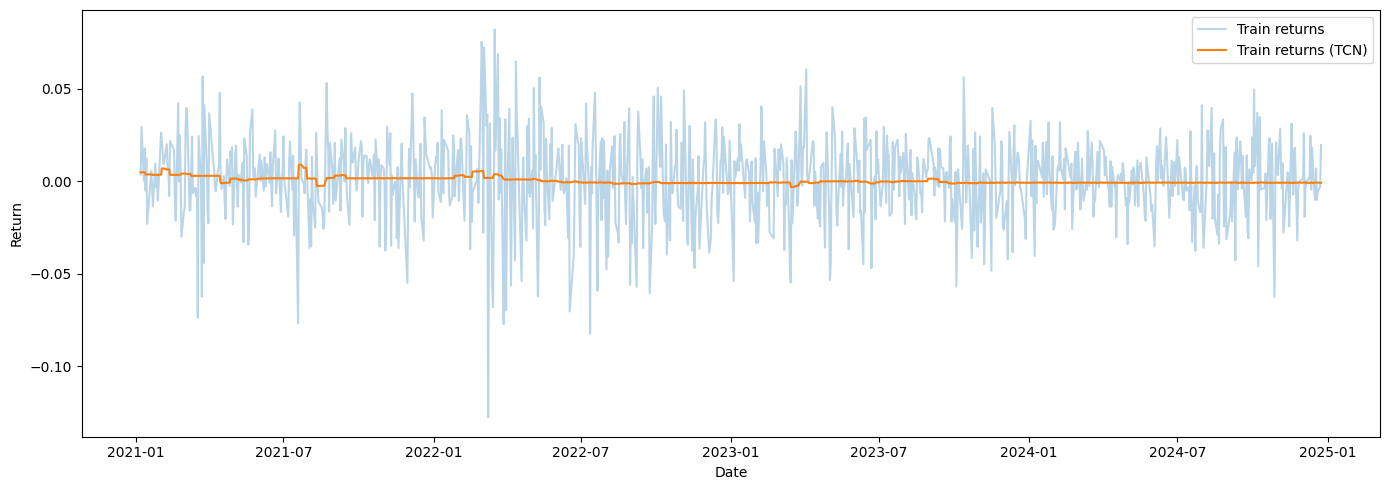

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_class_np, label = "Train returns (TCN)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Hybrid Additive AR(1)-TCN

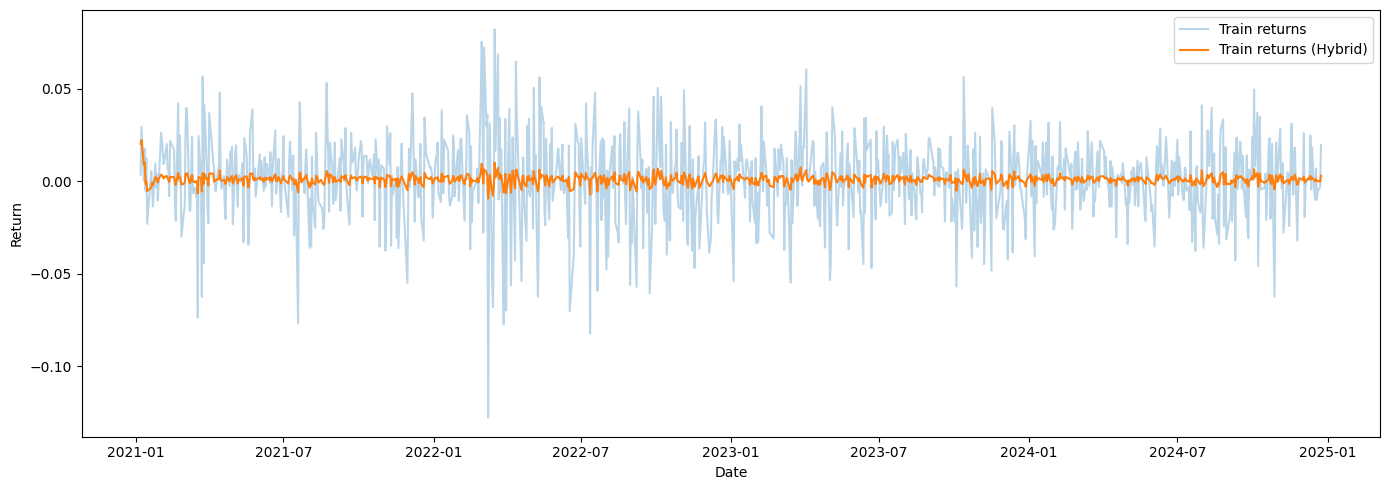

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_add1_np, label = "Train returns (Hybrid)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Hybrid Additive AR(5)-TCN

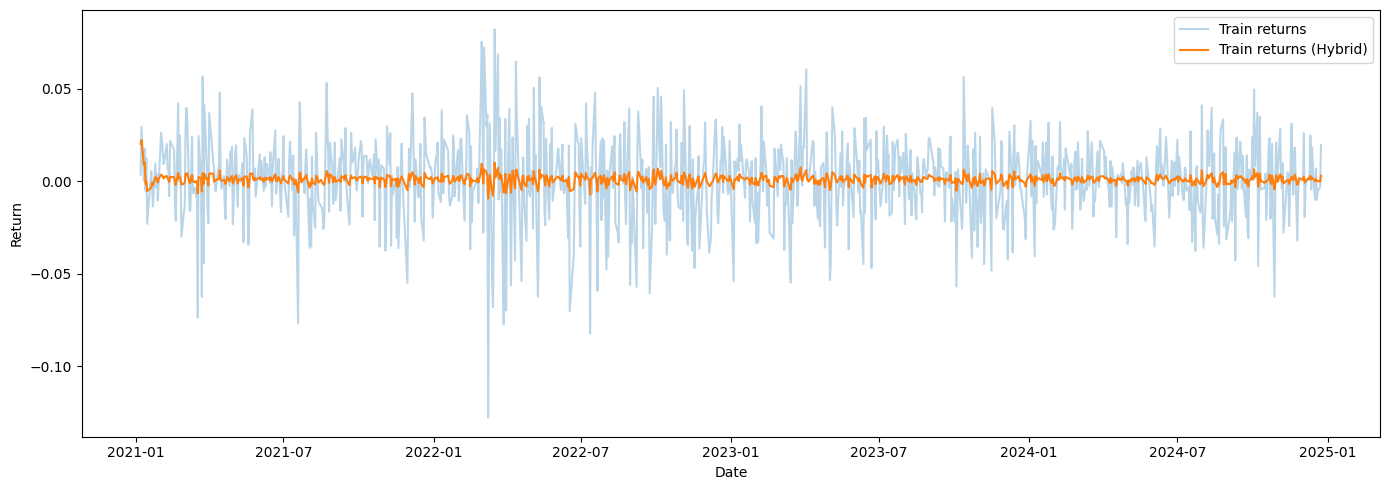

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_add5_np, label = "Train returns (Hybrid)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()